In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import copy
from pylab import rcParams

%matplotlib inline
rcParams['figure.figsize'] = 15, 10
warnings.filterwarnings('ignore')

In [2]:
# import and visualise data
parser = lambda dates: pd.datetime.strptime(dates,'%m/%d/%Y')
data = pd.read_csv('data.csv',
                   engine='python',parse_dates=[0], 
                   index_col = 'Time', 
                   date_parser = parser)

In [3]:
data.shape

(516, 1)

In [4]:
# The data starts from Jan 1976 to Dec 2018. 
data.head()

,Total arrivals
Time,
1976-01-01,203000
1976-02-01,137000
1976-03-01,119000
1976-04-01,102100
1976-05-01,129000


In [5]:
data.tail()

,Total arrivals
Time,
2018-08-01,1718600
2018-09-01,1722000
2018-10-01,1963700
2018-11-01,1668000
2018-12-01,1853600


In [6]:
def show_plot(
    data,
    figsize=(15, 10),
    color="blue",
    linestyle="-",
    xlabel="Time",
    ylabel="Total arrivals",
    label=None,
):
    plt.figure(figsize=figsize)
    plt.plot(data.index, data, color=color, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc=2)

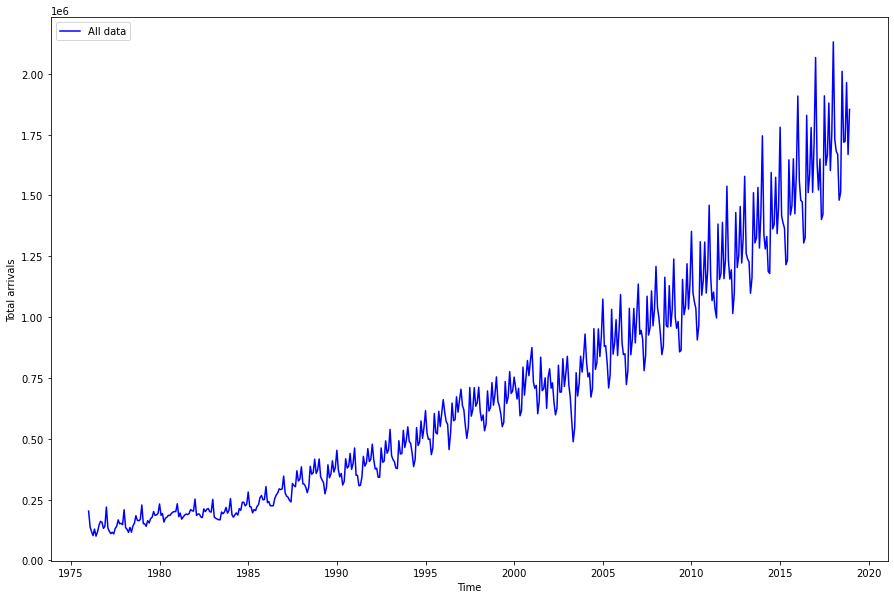

In [7]:
show_plot(data,label = 'All data')

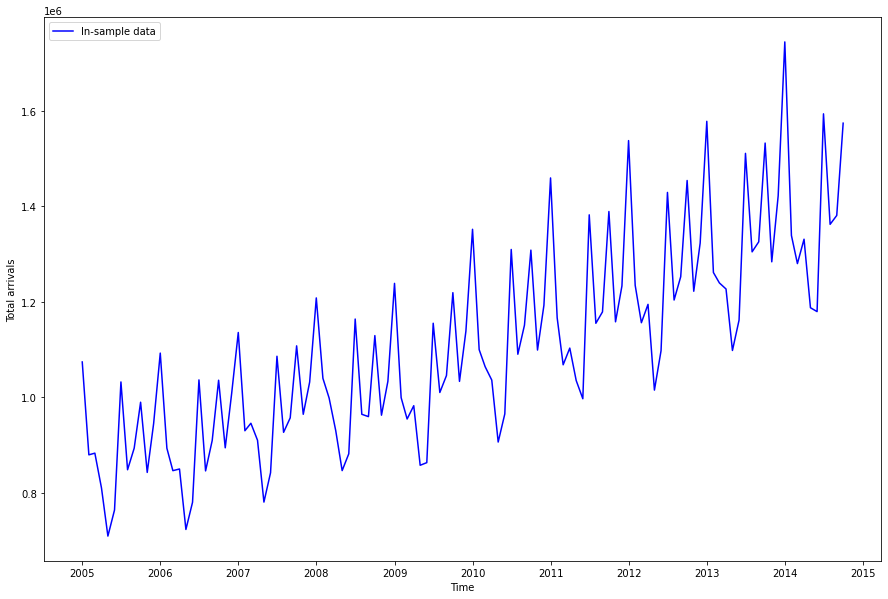

In [8]:
# cut down samples and train-test split.
def year_cut(data,time):   
    return data[time:]

def tt_split(data,seperator=0.7):
    try:
        n = int(data.shape[0]*seperator)
        return data[:n+1],data[n+1:]
    except:
        return data[:seperator],data[seperator:]

data_ten_y = year_cut(data,'Jan-2005') # Cut the original data from Jan 2005.
# First 70% data is used as in-sample data, the rest is out-of-sample. 
train, test = tt_split(data_ten_y) 
show_plot(train,label = 'In-sample data')

In [9]:
train.head()

,Total arrivals
Time,
2005-01-01,1073800
2005-02-01,879100
2005-03-01,882600
2005-04-01,809600
2005-05-01,708700


In [10]:
train.tail()

,Total arrivals
Time,
2014-06-01,1179400
2014-07-01,1594100
2014-08-01,1362400
2014-09-01,1381000
2014-10-01,1574500


In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [12]:
result = seasonal_decompose(train,model="additive",period=30)
result

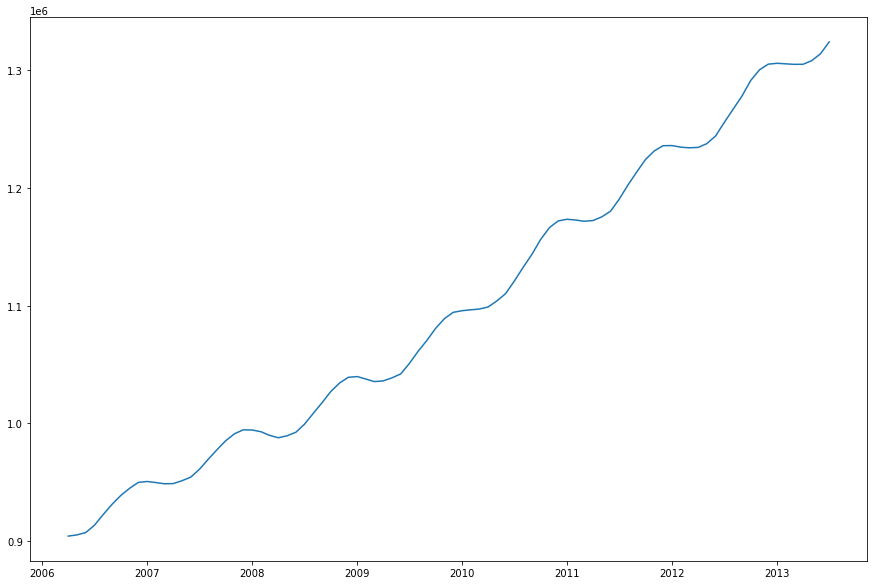

In [13]:
plt.plot(result.trend)

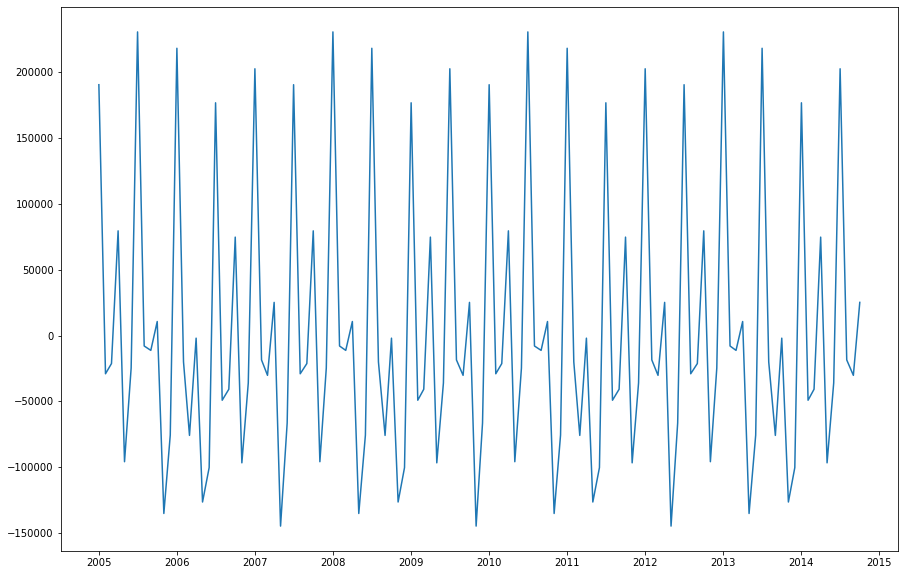

In [14]:
plt.plot(result.seasonal)

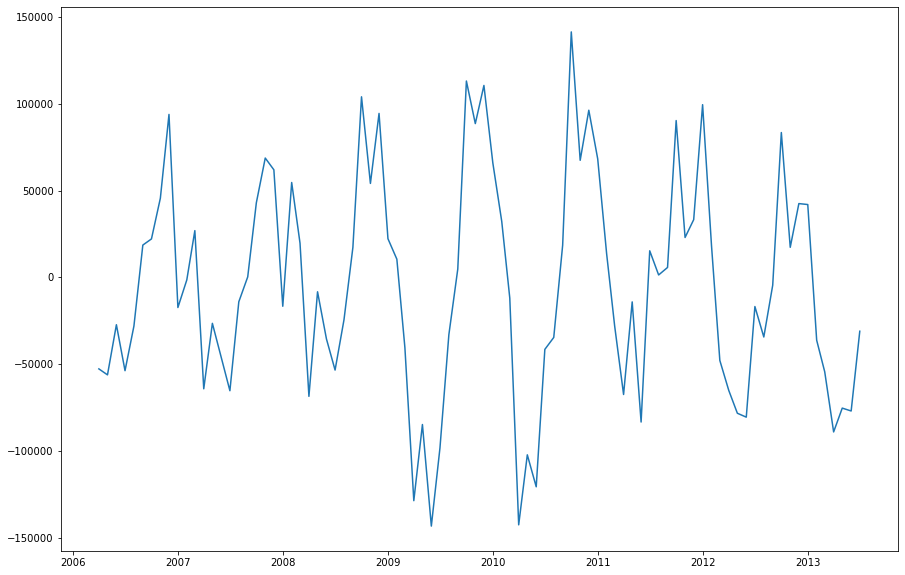

In [15]:
plt.plot(result.resid)

In [16]:
order=2
coef=np.polyfit(np.arange(len(train["Total arrivals"])),
                    train["Total arrivals"].values.ravel(),
                    order)
coef

array([1.90540432e+01, 2.61154811e+03, 8.67857588e+05])

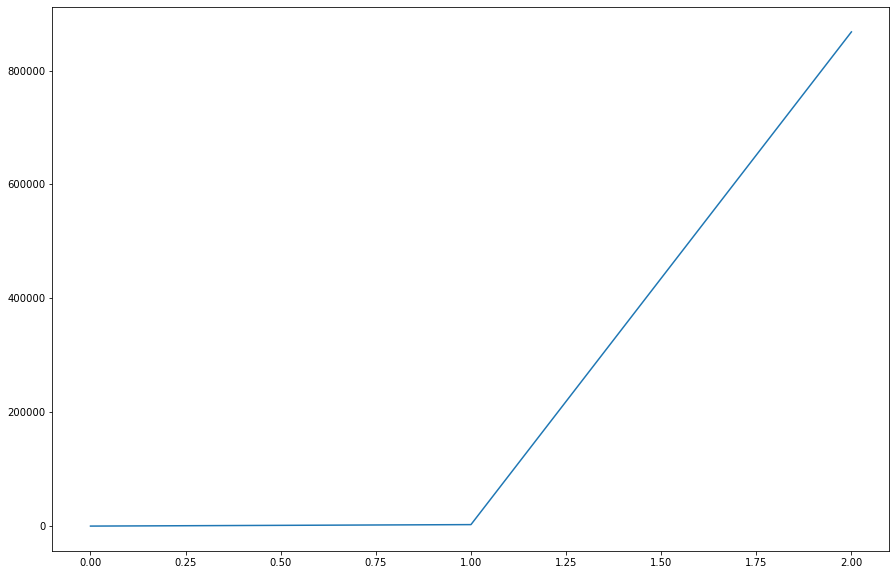

In [17]:
plt.plot(coef)

In [20]:
poly_mdl=np.poly1d(coef)
poly_mdl

poly1d([1.90540432e+01, 2.61154811e+03, 8.67857588e+05])

In [30]:
trend = pd.Series(data = poly_md1(np.arange(len(train['Total arrivals']))),
                  index = train.index)
trend

Time
2005-01-01    8.678576e+05
2005-02-01    8.704882e+05
2005-03-01    8.731569e+05
2005-04-01    8.758637e+05
2005-05-01    8.786086e+05
                  ...     
2014-06-01    1.406264e+06
2014-07-01    1.413200e+06
2014-08-01    1.420175e+06
2014-09-01    1.427188e+06
2014-10-01    1.434240e+06
Length: 118, dtype: float64

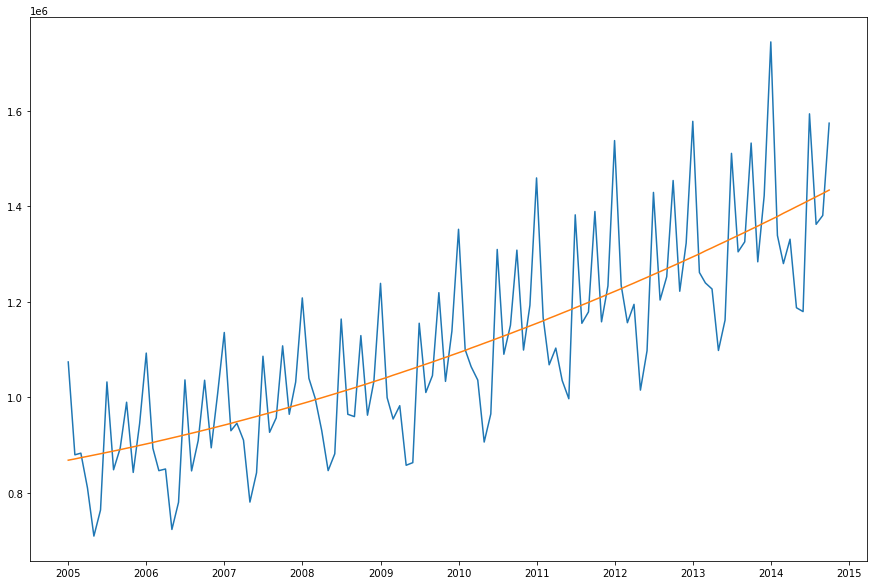

In [22]:
plt.plot(train)
plt.plot(trend)
plt.show()

In [29]:
detrended = train['Total arrivals'] - trend
detrended

Time
2005-01-01    205942.412050
2005-02-01      8611.809900
2005-03-01      9443.099664
2005-04-01    -66263.718658
2005-05-01   -169908.645067
                  ...      
2014-06-01   -226863.601443
2014-07-01    180899.582647
2014-08-01    -57775.341350
2014-09-01    -46188.373433
2014-10-01    140260.486398
Length: 118, dtype: float64

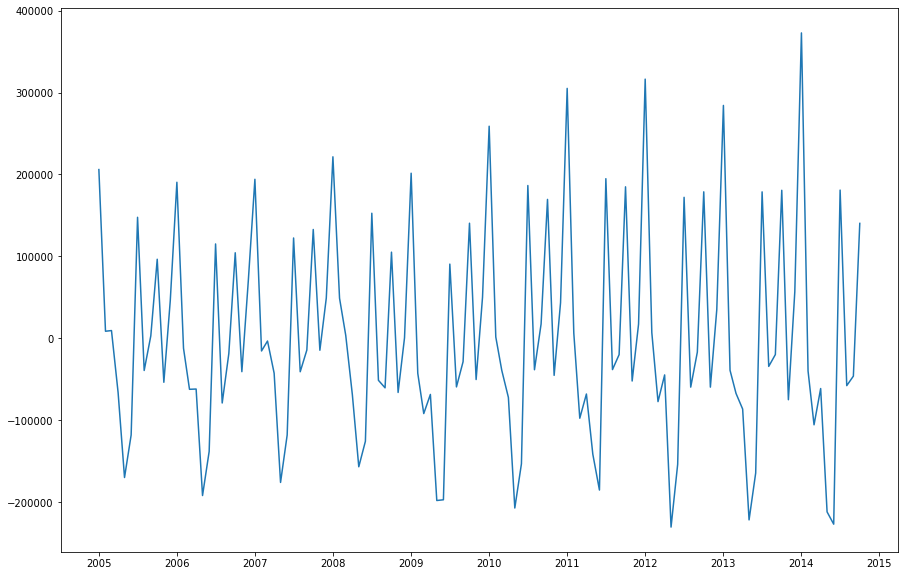

In [24]:
plt.plot(detrended)

In [28]:
seasonal = detrended.groupby(by = detrended.index.month).mean()
seasonal

Time
1     255071.021060
2      -7667.417754
3     -53123.964655
4     -64068.619641
5    -190511.382714
6    -158042.253874
7     154148.766880
8     -49788.320452
9     -20433.515870
10    143343.180625
11    -50817.060867
12     40897.623529
dtype: float64

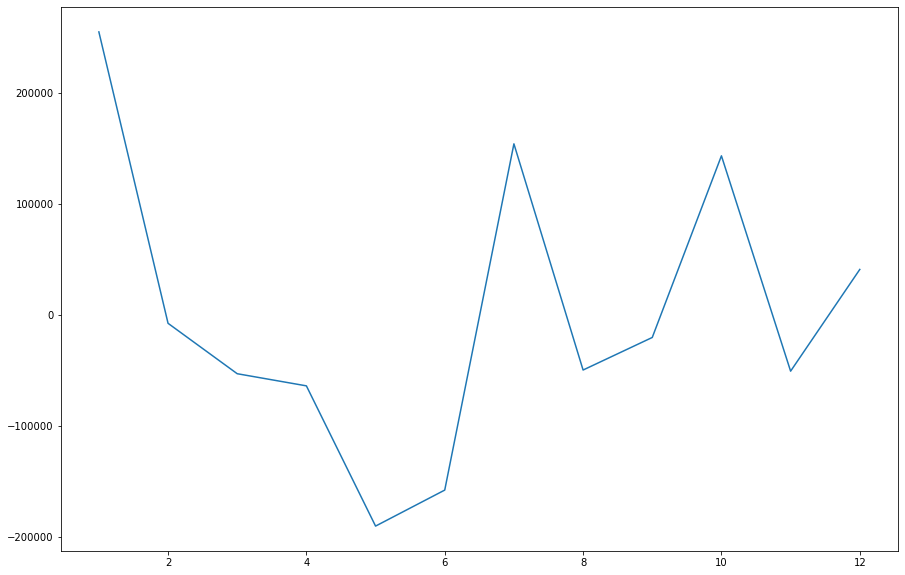

In [26]:
plt.plot(seasonal)

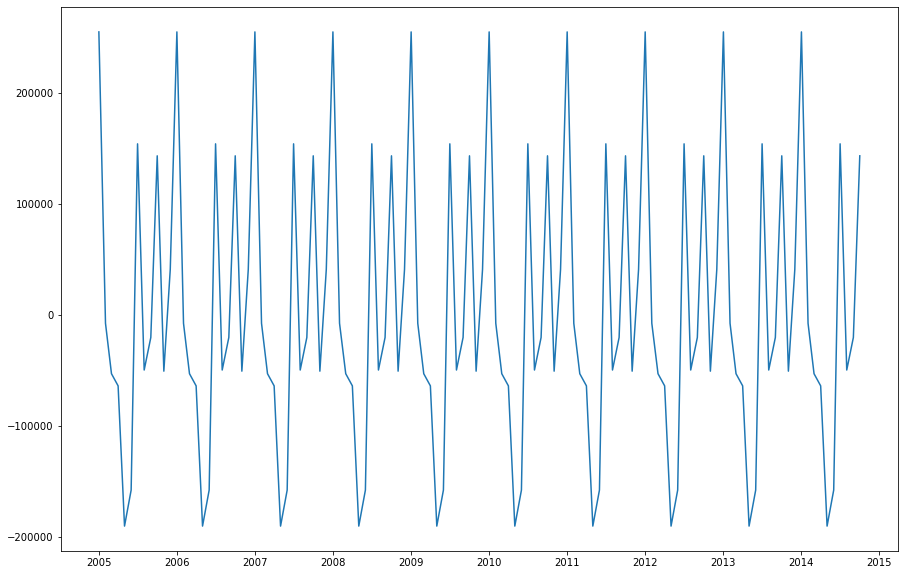

In [27]:
col = 'Total arrivals'
seasonal_component = copy.deepcopy(train)
for i in seasonal.index:
    seasonal_component.loc[seasonal_component.index.month == i, col] = seasonal.loc[i]
plt.plot(seasonal_component)

In [32]:
deseasonal = train - seasonal_component
deseasonal

,Total arrivals
Time,
2005-01-01,8.187290e+05
2005-02-01,8.867674e+05
2005-03-01,9.357240e+05
2005-04-01,8.736686e+05
2005-05-01,8.992114e+05
...,...
2014-06-01,1.337442e+06
2014-07-01,1.439951e+06
2014-08-01,1.412188e+06


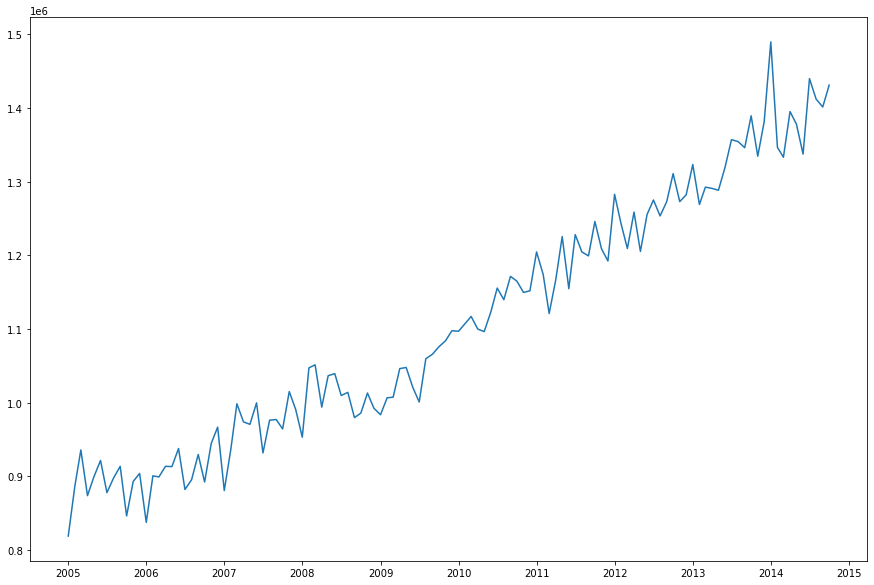

In [33]:
plt.plot(deseasonal)

In [34]:
coef = np.polyfit(np.arange(len(deseasonal)), deseasonal['Total arrivals'], order)
coef

array([1.83276298e+01, 2.70780761e+03, 8.65555196e+05])

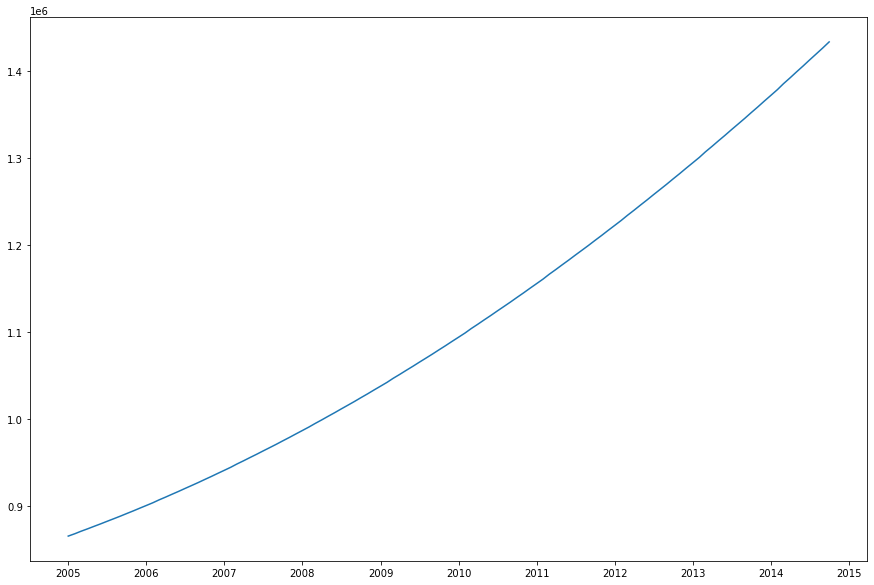

In [35]:
poly_mdl = np.poly1d(coef)
trend_comp = pd.DataFrame(data = poly_mdl(np.arange(len(train['Total arrivals']))),
                          index = train.index,
                          columns=['Total arrivals'])
plt.plot(trend_comp)

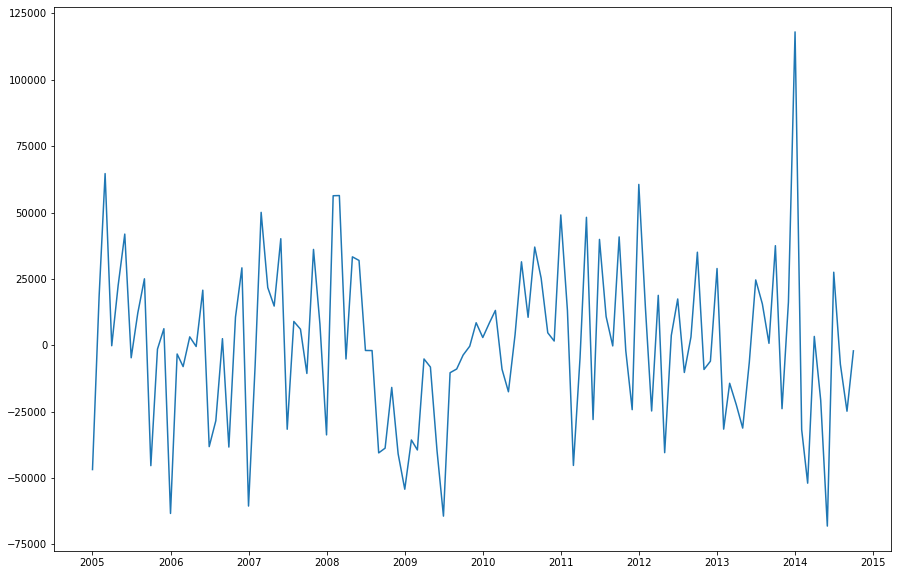

In [36]:
residual = train - seasonal_component - trend_comp
plt.plot(residual)

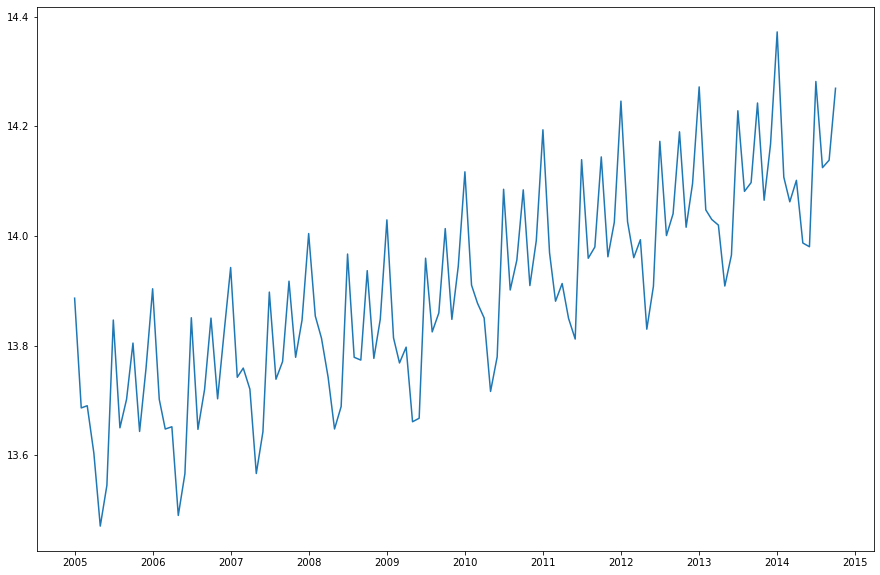

In [37]:
plt.plot(np.log(train))

In [40]:
result_log = seasonal_decompose(np.log(train), model='additive', period=30)

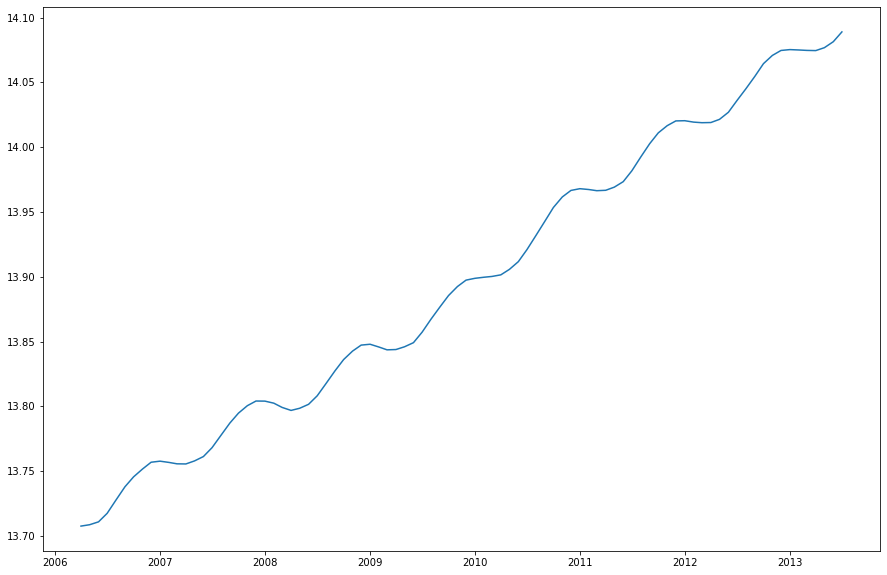

In [41]:
plt.plot(result_log.trend)

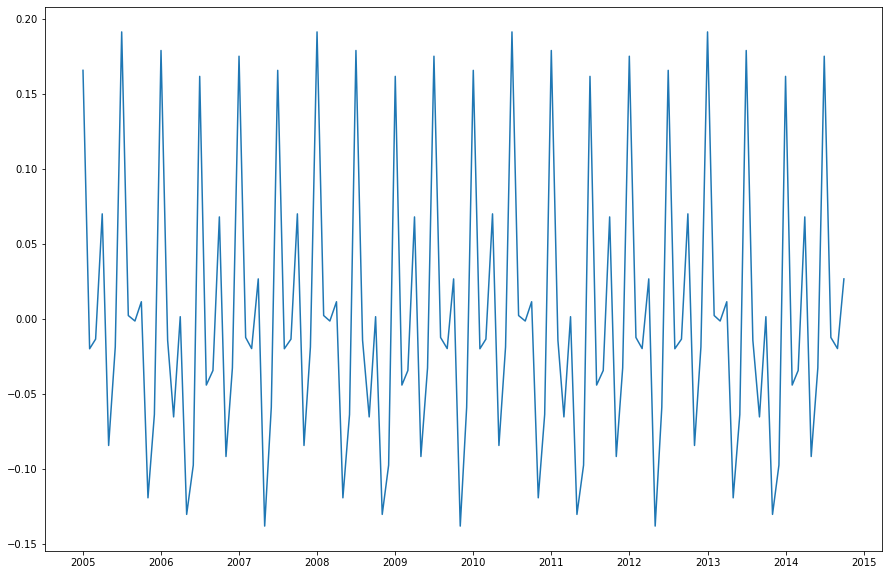

In [42]:
plt.plot(result_log.seasonal)

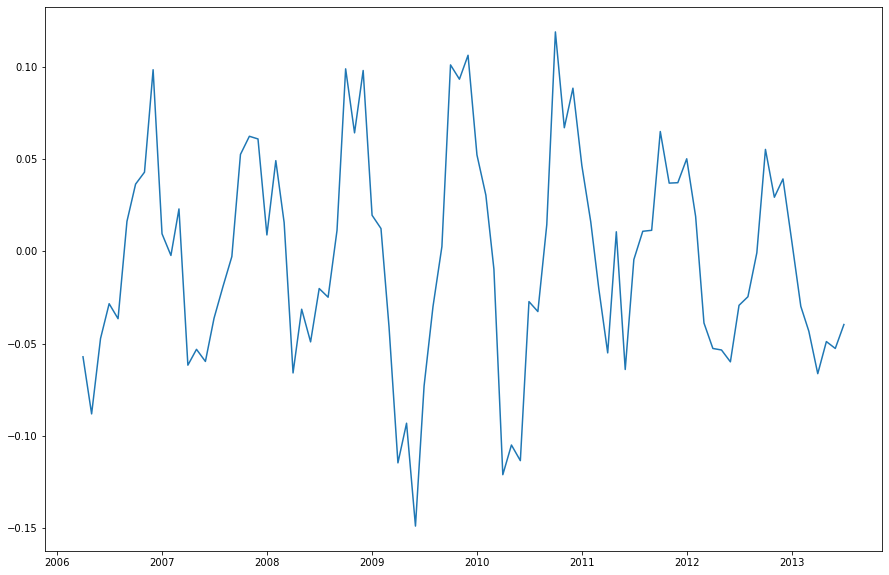

In [43]:
plt.plot(result_log.resid)

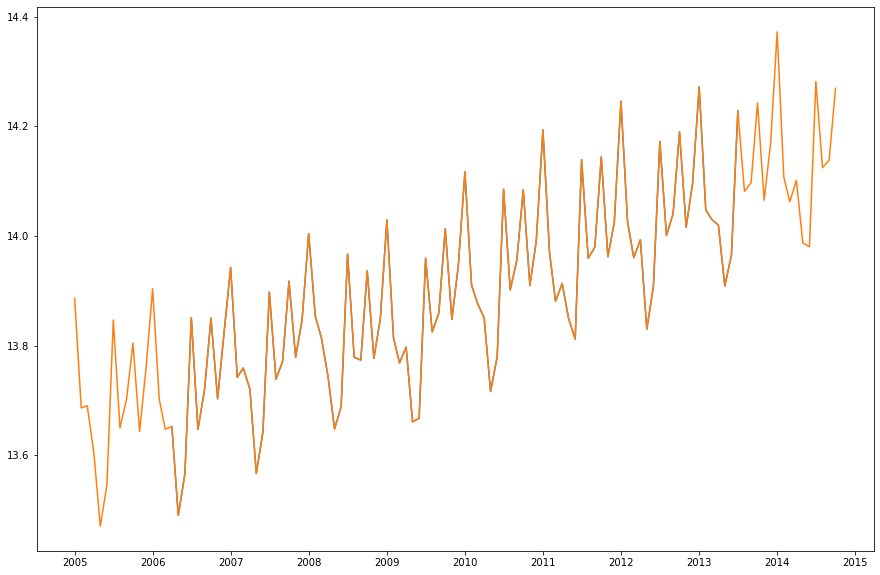

In [44]:
plt.plot(result_log.resid + result_log.trend + result_log.seasonal)
plt.plot(np.log(train))
plt.show()